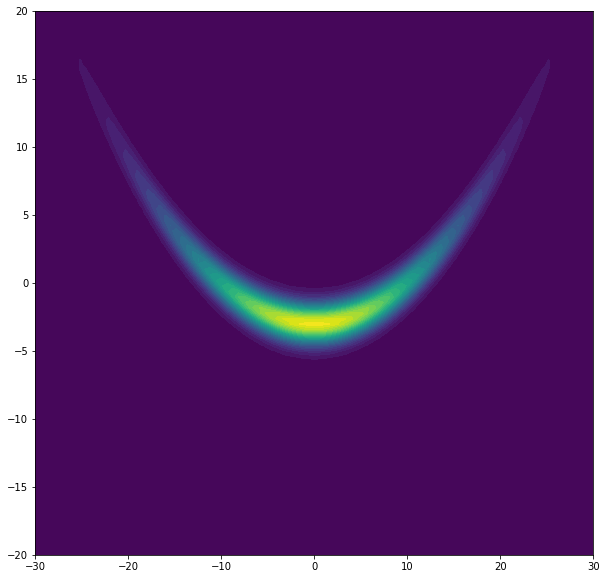

In [1]:
import torch
import matplotlib.pyplot as plt
from stein_mpc.distributions.banana import Banana

grid_size = 100
d = Banana(bananicity=0.03 ,V=100)
min_b, max_b = d.get_plotting_bounds()
# x = torch.linspace(min_b[0], max_b[0], grid_size)
# y = torch.linspace(min_b[0], max_b[0], grid_size)
x = torch.linspace(-30, 30, grid_size)
y = torch.linspace(-20, 20, grid_size)
X, Y = torch.meshgrid(x, y)
Z = torch.exp(d.log_prob(torch.stack((X.flatten(), Y.flatten()), dim=0).T)).reshape(
    grid_size, grid_size
)

fig, ax = plt.subplots(figsize=(10, 10))
ax.contourf(X.cpu(), Y.cpu(), Z.data.cpu().numpy(), 30, cmap=plt.get_cmap("viridis"))

In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import sigkernel
from torch.distributions import MultivariateNormal
from stein_mpc.inference import SVGD
from stein_mpc.kernels import GaussianKernel, TrajectoryKernel, PathSigKernel, SignatureKernel
from stein_mpc.utils.math import bw_silverman, pw_dist_sq
from stein_mpc.utils.helper import set_seed, generate_seeds

# mpl.rc('font', **{'family':'serif', 'serif':['Times New Roman']})
mpl.rcParams['text.latex.preamble'] = r"\usepackage{amsmath} \usepackage{times}"
#Options
params = {'text.usetex': True,
          'font.size': 11,
          'font.family': 'serif',
          'font.serif': ['Times New Roman'], 
          }
mpl.rcParams.update(params) 

if torch.cuda.is_available():
    ctx = {"device": "cuda"}
else:
    ctx = {"device": "cpu"}

seed = generate_seeds(1)
set_seed(seed[0])
print(f"Using seed {seed[0]}")

Using seed 287199692


In [2]:
# Sets up hyperparams and the optimization problem
batch = 100
length = 10
channels = 2
shape = (batch, length, channels)
opt_class = torch.optim.Adam
lr = 0.05
n_iter = 200

path_dist = MultivariateNormal(loc=torch.zeros(length * channels, **ctx), covariance_matrix=torch.eye(length * channels, **ctx))
plot_dist = MultivariateNormal(loc=torch.zeros(length, channels, **ctx), covariance_matrix=torch.eye(channels, **ctx))
init_particles = torch.empty(batch, length, channels, **ctx).uniform_(-2, 2) + plot_dist.mean

dists = pw_dist_sq(init_particles.flatten(1).cpu(), init_particles.flatten(1).cpu())
bw = bw_silverman(dists).mean()
print(f"Gaussian Kernel bandwidth computed with Silverman's: {bw.item()}")

Gaussian Kernel bandwidth computed with Silverman's: 5.00588846206665


In [3]:
# Check distribution is well defined
path_dist.log_prob(init_particles.flatten(1))
assert(path_dist.log_prob(init_particles.flatten(1)).shape == init_particles.shape[:1])

In [4]:
# Plotting
scatter_cmap = mpl.cm.RdYlGn
dist_cmap = mpl.cm.Greys_r

def plot2d(ax, tensor, values, dim, ngrid):
    x_lim = torch.tensor([-2, 2], **ctx) + plot_dist.mean[dim, 0]
    y_lim = torch.tensor([-2, 2], **ctx) + plot_dist.mean[dim, 1]
    x = torch.linspace(*x_lim, ngrid, **ctx)
    y = torch.linspace(*y_lim, ngrid, **ctx)
    X, Y = torch.meshgrid(x,y)
    Z = plot_dist.log_prob(torch.stack((X.flatten()[:, None], Y.flatten()[:, None]), dim=-1))[..., dim]
    Z = Z.exp().reshape(ngrid, ngrid)

    ax.contourf(X.cpu(), Y.cpu(), Z.data.cpu().numpy(), 30, cmap=dist_cmap)
    ax.set_xlim(x_lim.cpu())
    ax.set_ylim(y_lim.cpu()) 
    ax.scatter(tensor[:, dim, 0].cpu().numpy(), tensor[:, dim, 1].cpu().numpy(), s=30, c=values, cmap=scatter_cmap, alpha=0.7, edgecolors='black')

In [16]:
# Batch optimization using SVGD
def estimator(x):
    log_p = path_dist.log_prob(x.flatten(1))
    grad_log_p = torch.autograd.grad(log_p.sum(), x, retain_graph=True)[0]
    k_xx = kernel(x.flatten(1).detach(), x.flatten(1), compute_grad=False)
    grad_k = torch.autograd.grad(k_xx.sum(), x)[0]
    score_dict = {
        "k_xx": k_xx.detach(),
        "grad_k": grad_k.detach(),
        "loss": -log_p,
    }
    return grad_log_p, score_dict

kernel = GaussianKernel(bandwidth_fn=lambda _: 5)
# stein_sampler = SVGD(kernel, log_p=path_dist.log_prob, optimizer_class=opt_class, lr=lr)
stein_sampler = SVGD(kernel, optimizer_class=opt_class, lr=lr)

svgd_particles = init_particles.clone().flatten(1)
stein_sampler.optimize(svgd_particles, n_steps=n_iter, score_estimator=estimator)
# Ensure the initial particles have moved
assert(torch.allclose(svgd_particles, init_particles.flatten(1)) == False)
print(f"Variance of particles at each timestep: {svgd_particles.reshape(shape).var(dim=[0, 2]).tolist()}")

Variance of particles at each timestep: [9.133142020445462e-10, 1.2469592025610154e-09, 1.0565849306587438e-09, 1.383954284506217e-09, 9.088859664885263e-10, 1.1825944667975818e-09, 1.142631655959292e-09, 9.667541212010633e-10, 1.2498092560875307e-09, 1.0792038374063395e-09]


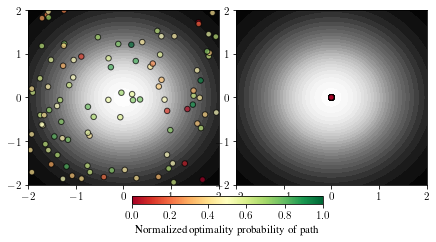

In [17]:
dim = 5
ngrid = 100
fig = plt.figure(figsize=(7.14, 7.14/2))
gs = mpl.gridspec.GridSpec(20, 4, figure=fig)
ax1 = fig.add_subplot(gs[:18, :2])
ax2 = fig.add_subplot(gs[:18, 2:])
ax3 = fig.add_subplot(gs[19, 1:3])

init_probs = path_dist.log_prob(init_particles.flatten(1)).cpu()
svgd_probs = path_dist.log_prob(svgd_particles.flatten(1)).cpu()
plot2d(ax1, init_particles.reshape(shape).cpu(), init_probs, dim, 100)
plot2d(ax2, svgd_particles.reshape(shape).cpu(), svgd_probs, dim, 100)
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(), cmap=scatter_cmap), cax=ax3, orientation="horizontal", label="Normalized optimality probability of path")
plt.show()

In [65]:
# Batch optimization using SGD
def estimator(x):
    log_p = path_dist.log_prob(x.flatten(1))
    grad_log_p = torch.autograd.grad(log_p.sum(), x, retain_graph=True)[0]
    k_xx = torch.eye(x.shape[0])
    grad_k = torch.zeros_like(grad_log_p)
    score_dict = {
        "k_xx": k_xx.detach(),
        "grad_k": grad_k.detach(),
        "loss": -log_p,
    }
    return grad_log_p, score_dict

kernel = GaussianKernel()
stein_sampler = SVGD(kernel, optimizer_class=opt_class, lr=lr)

sgd_particles = init_particles.clone()
stein_sampler.optimize(sgd_particles, score_estimator=estimator, n_steps=n_iter)
# Ensure the initial particles have moved
assert(torch.allclose(particles, init_particles) == False)
print(f"Variance of particles at each timestep: {sgd_particles.var(dim=[0, 2]).tolist()}")

Variance of particles at each timestep: [9.978606829719183e-10, 1.4417541605027395e-09, 1.0023550878202059e-09, 1.0864875665816953e-09, 1.3264659370904042e-09, 9.649295806823943e-10, 1.043447106496842e-09, 1.2705518859235099e-09, 1.0049169274495284e-09, 9.901346409435519e-10]


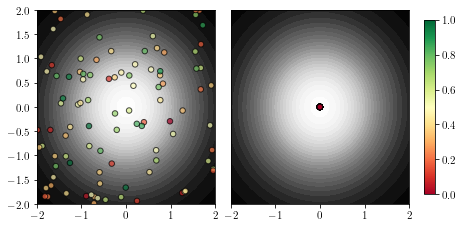

In [67]:
dim = 4
ngrid = 100
fig = plt.figure(figsize=(7.14, 7.14/2))
gs = mpl.gridspec.GridSpec(20, 31, figure=fig)
ax1 = fig.add_subplot(gs[:, :14])
ax2 = fig.add_subplot(gs[:, 15:29])
ax3 = fig.add_subplot(gs[1:-1, 30])

init_probs = path_dist.log_prob(init_particles.flatten(1)).cpu()
sgd_probs = path_dist.log_prob(sgd_particles.flatten(1)).cpu()
plot2d(ax1, init_particles.reshape(shape).cpu(), init_probs, dim, 100)
plot2d(ax2, sgd_particles.reshape(shape).cpu(), sgd_probs, dim, 100)
ax2.set_yticks([])
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(), cmap=scatter_cmap), cax=ax3)
plt.show()

In [34]:
# Batch optimization using Path Signature
def estimator(x):
    log_p = path_dist.log_prob(x.flatten(1))
    grad_log_p = torch.autograd.grad(log_p.sum(), x, retain_graph=True)[0]
    k_xx = kernel(x, x)
    grad_k = -1 * torch.autograd.grad(k_xx.sum(), x)[0]  # TODO: Check if this is needed
    score_dict = {
        "k_xx": k_xx.detach(),
        "grad_k": grad_k.detach(),
        "loss": -log_p,
    }
    return grad_log_p, score_dict

kernel = SignatureKernel(bandwidth_fn=lambda _: 5, depth=4)
stein_sampler = SVGD(kernel, optimizer_class=opt_class, lr=lr)

particles = init_particles.clone()
stein_sampler.optimize(particles, score_estimator=estimator, n_steps=n_iter)
# Ensure the initial particles have moved
assert(torch.allclose(particles, init_particles) == False)
print(f"Variance of particles at each timestep: {particles.var(dim=[0, 2]).tolist()}")

Variance of particles at each timestep: [0.05162423104047775, 0.5656667351722717, 0.6224484443664551, 0.5866155028343201, 1.2819126844406128, 0.7014585137367249, 0.6722050905227661, 0.5762863755226135, 0.43797892332077026, 0.10047882795333862]


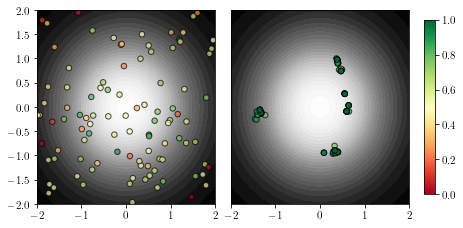

In [35]:
dim = 6
ngrid = 100
fig = plt.figure(figsize=(7.14, 7.14/2))
gs = mpl.gridspec.GridSpec(20, 31, figure=fig)
ax1 = fig.add_subplot(gs[:, :14])
ax2 = fig.add_subplot(gs[:, 15:29])
ax3 = fig.add_subplot(gs[1:-1, 30])

init_probs = path_dist.log_prob(init_particles.flatten(1)).cpu()
sig_probs = path_dist.log_prob(particles.flatten(1)).cpu()
plot2d(ax1, init_particles.reshape(shape).cpu(), init_probs, dim, 100)
plot2d(ax2, particles.reshape(shape).cpu(), sig_probs, dim, 100)
ax2.set_yticks([])
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(), cmap=scatter_cmap), cax=ax3)
plt.show()

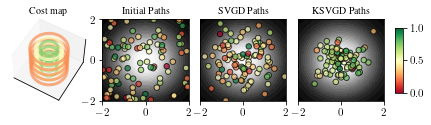

In [142]:
dim = 9
ngrid = 100
fig = plt.figure(figsize=(7.14, 1.5))
gs = mpl.gridspec.GridSpec(10, 41, figure=fig)
ax0 = fig.add_subplot(gs[:, :9], projection="3d")
ax1 = fig.add_subplot(gs[:, 10:19])
ax2 = fig.add_subplot(gs[:, 20:29], sharex=ax1)
ax3 = fig.add_subplot(gs[:, 30:39], sharex=ax1)
ax4 = fig.add_subplot(gs[1:-1, -1])

x_lim = torch.tensor([-2, 2])
y_lim = torch.tensor([-2, 2])
x = torch.linspace(*x_lim, ngrid)
y = torch.linspace(*y_lim, ngrid)
X, Y = torch.meshgrid(x,y)
levels = torch.linspace(0.0029, 0.1591, 5).numpy()
for dim in range(5):
    Z = plot_dist.log_prob(torch.stack((X.flatten()[:, None], Y.flatten()[:, None]), dim=-1))[..., dim]
    Z = dim + Z.exp().reshape(ngrid, ngrid)
    ax0.contour(X, Y, Z.data, levels=dim+levels, cmap=scatter_cmap, linewidths=3, alpha=0.7)


init_probs = path_dist.log_prob(init_particles.flatten(1)).cpu()
sig_probs = path_dist.log_prob(particles.flatten(1)).cpu()
plot2d(ax1, init_particles.reshape(shape).cpu(), init_probs, dim, 100)
plot2d(ax2, svgd_particles.reshape(shape).cpu(), svgd_probs, dim, 100)
plot2d(ax3, particles.reshape(shape).cpu(), sig_probs, dim, 100)
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(), cmap=scatter_cmap), cax=ax4)

ax0.set_title("Cost map", fontsize=10)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_zticks([])
ax0.view_init(55)
ax1.set_title("Initial Paths", fontsize=10)
ax1.set_yticks([-2, 0, 2])
ax2.set_title("SVGD Paths", fontsize=10)
ax2.set_yticks([])
ax3.set_title("KSVGD Paths", fontsize=10)
ax3.set_yticks([])
ax1.set_xticks([-2, 0, 2])
plt.savefig("sequential_distribution.pdf", bbox_inches="tight", dpi=1000)

In [ ]:
print(f"Highest optimality likelihood for KSVGD: {sig_probs.max()}")
print(f"Average optimality likelihood for KSVGD: {sig_probs.mean()}")
print(f"Average path length for KSVGD: {(particles[1:] - particles[:-1]).norm(dim=[1, 2]).mean()}")

print(f"Highest optimality likelihood for SVGD: {svgd_probs.max()}")
print(f"Average optimality likelihood for SVGD: {svgd_probs.mean()}")
print(f"Average path length for SVGD: {(svgd_particles.reshape(shape)[1:] - svgd_particles.reshape(shape)[:-1]).norm(dim=[1, 2]).mean()}")

Highest optimality likelihood for KSVGD: -19.67019271850586
Average optimality likelihood for KSVGD: -21.150619506835938
Average path length for KSVGD: 3.2980997562408447
Highest optimality likelihood for SVGD: -24.73861312866211
Average optimality likelihood for SVGD: -24.970548629760742
Average path length for SVGD: 5.145798683166504


NameError: name 'dist' is not defined

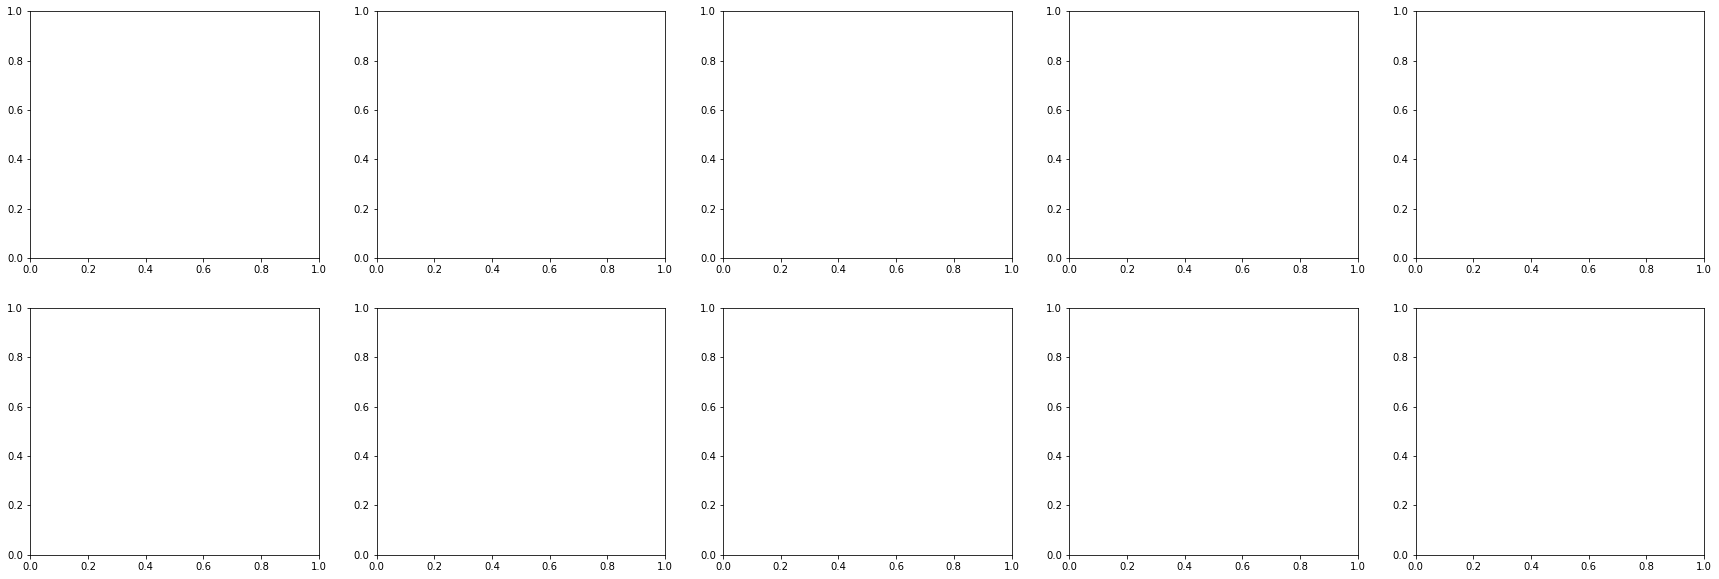

In [ ]:
# Plotting
fig, ax = plt.subplots(2, 5, figsize=(30, 10))
for i in range(length):
    cur_ax = ax.flatten()[i]
    dist.plot_2d(dim=i, ax=cur_ax, padding=1.25)
    cur_ax.scatter(particles[:, i, 0].cpu().numpy(), particles[:, i, 1].cpu().numpy(), s=50, c="red", alpha=0.3)
plt.show()

: 